In [2]:
import scanpy as sc
from CITEsort_rna.metadimm import MetaDIMM
import numpy as np
import pandas as pd
from CITEsort_rna.BTreeTraversal import BTreeTraversal
from CITEsort_rna.Visualize import plot_keymarker,visualize_tree
import pickle

In [3]:
id='5_4'

adata = sc.read_h5ad('../SeuratV3/subdata/'+id+'_RNA.h5ad')
label = adata.obs['label']
label.name = 'cell_type'
# adata = sc.read_h5ad('../simulator_out/RNA_simulator_'+id+'.h5ad')

# label = pd.read_csv('../simulator_out/droplets_composition_'+id+'.csv',index_col=0)
# label['cell_type'] = label.loc[:,'0'].astype(str)
# label.index = label.index.astype(str)
adata.obs['label'] = label#['cell_type']

f = open('../output/'+id+'_rna/cuttree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()
traversal = BTreeTraversal(tree)
md = MetaDIMM()
adata = adata[tree.indices,:]
# adata = md.filter(adata)
adata = md.preprocess(adata, normalize=True, log1p=True, hvg=True, scale=True)

pred_rna = pd.read_csv('../output/'+id+'_rna/cut_leaf_labels.csv',index_col=0)
pred_rna.index  = pred_rna.index.astype(str)
adata.obs['pred_rna'] = pd.Categorical(pred_rna['Label'])
# sc.tl.rank_genes_groups(adata, groupby='pred_rna', method='t-test')

/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


---------------------------------------
Function 'preprocess' executed in 7.18s
---------------------------------------


In [226]:
f = open('../output/'+id+'_rna/cuttree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()
traversal = BTreeTraversal(tree)

In [94]:
tp = pd.read_csv('../data/bmmc/RNA_PBMC_1.csv')
# tp.T.to_csv('../data/bmmc/RNA_BMMC_1.csv')

In [95]:
tp.iloc[:2,:2]

,PBMC_D4T1.AAACCCAAGATTGTGA.1,PBMC_D4T1.AAACCCACATCGGTTA.1
0,0,0
1,0,0


In [66]:
idnew = '5_5'

adata_new = sc.read_h5ad('../data/tumor/CZWY_celltype.h5ad')
# adata_new = sc.read_csv('../data/bmmc/RNA_BMMC_2.csv').T
# adata_new = sc.read_h5ad('../SeuratV3/subdata/'+idnew+'_RNA.h5ad')
# adata_new = sc.read_h5ad('../simulator_out/RNA_simulator_'+idnew+'.h5ad')
# sc.pp.filter_cells(adata_new, min_genes=100)
# adata_npp = md.preprocess(adata_new, normalize=True, log1p=True, hvg=False, scale=True)

In [50]:
sc.tl.pca(adata_sub[:,genes], n_comps=5)

## Fine tune leaf nodes

In [41]:
# nodeID = [6,13]
# nodelist, leaves_labels = traversal.get_leaf_label(finetune=True, method='bfs',nodeID=nodeID)
# leaves_labels.to_csv('../output/'+id+'_rna/cut_leaf_labels.csv')
# adata.obs['cutpred'] = leaves_labels['Label']

In [37]:
# adata_new = adata_new.T
adata_new.var_names

Index(['FAM138A', 'OR4F5', 'AL627309.1', 'OR4F29', 'OR4F16', 'FAM87B',
       'LINC00115', 'FAM41C', 'AL645608.2', 'SAMD11',
       ...
       'LSS', 'AP001468.1', 'MCM3AP-AS1', 'MCM3AP', 'YBEY', 'C21orf58', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', length=20287)

In [68]:
adata_npp = adata_new.copy()

In [69]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


newdict = dict()
dedict = dict()
coefdict = dict()
newdict[0] = adata_npp.obs_names
ind = 0
pred_new = pd.Series(index=adata_new.obs_names,dtype='object')
nodelist = traversal.nodelist

for node in nodelist:
    if node.left != None:
        if node.ind == 24:
            pred_new.loc[newdict[node.ind]] = 16
            continue
        if node.ind == 27:
            pred_new.loc[newdict[node.ind]] = 20
            continue
        if node.ind == 9:
            pred_new.loc[newdict[node.ind]] = 31
            continue
        adata_sub = adata[node.indices,:].copy()
        sc.pp.filter_genes(adata_sub, min_cells=3)
        adata_sub.obs['node_split'] = pd.Series(dtype='object')
        adata_sub.obs['node_split'].loc[set(node.left.indices)&set(node.indices)] = str(0)
        adata_sub.obs['node_split'].loc[set(node.right.indices)&set(node.indices)] = str(1)
        sc.tl.rank_genes_groups(adata_sub, groupby='node_split', method='t-test', n_genes=4000)
        DE_genes = pd.DataFrame(adata_sub.uns['rank_genes_groups']['names'][:500])
        genes = list(set(list(DE_genes.loc[:,'0'])+list(DE_genes.loc[:,'1']))&set(adata_npp.var_names))

        clf = LinearDiscriminantAnalysis()
        clf.fit(adata_sub[adata_sub.obs['node_split'].isin(['0','1']),genes].X, adata_sub[adata_sub.obs['node_split'].isin(['0','1']),:].obs['node_split'])

        
        adata_sub = adata_npp[newdict[ind],genes].copy()
        if len(newdict[ind]) == 0:
            pred = pd.Series('2',index=adata_sub.obs_names)
        else:
            pred = pd.Series(clf.predict(adata_sub.X),index=adata_sub.obs_names)
        maxind = max(newdict.keys())
        newdict[node.left.ind] = adata_sub[pred=='0',:].obs_names
        newdict[node.right.ind] = adata_sub[pred=='1',:].obs_names
        dedict[node.left.ind] = DE_genes.loc[:,'0'].values
        dedict[node.right.ind] = DE_genes.loc[:,'1'].values
        coefdict[node.ind] = clf.coef_

        # print(node.left.ind,node.right.ind)
    if node.key == ('leaf',):
        print(node.ind)
        pred_new.loc[newdict[node.ind]] = node.ind

    ind = ind+1
    # break

/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_gro

6


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_gro

9
10


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


12


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


14


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


15
16


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_gro

19
20


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


24


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


25


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


27
28


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


31
32


In [112]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

queue = [] 
newdict = dict()
dedict = dict()
queue.append(tree) 
newdict[0] = adata_npp.obs_names
ind = 0
pred_new = pd.Series(index=adata_new.obs_names,dtype='object')

while(len(queue) > 0): 
    node = queue.pop(0) 
    if node.left is not None:
        queue.append(node.left)
        queue.append(node.right) 

        adata_sub = adata[node.indices,:].copy()
        sc.pp.filter_genes(adata_sub, min_cells=3)
        adata_sub.obs['node_split'] = pd.Series(dtype='object')
        adata_sub.obs['node_split'].loc[node.left.indices] = str(0)
        adata_sub.obs['node_split'].loc[node.right.indices] = str(1)
        sc.tl.rank_genes_groups(adata_sub, groupby='node_split', method='t-test', n_genes=2000)
        DE_genes = pd.DataFrame(adata_sub.uns['rank_genes_groups']['names'][:1000])
        genes = list(set(list(DE_genes.loc[:,'0'])+list(DE_genes.loc[:,'1'])))

        clf = LinearDiscriminantAnalysis()
        clf.fit(adata_sub[adata_sub.obs['node_split'].isin(['0','1']),genes].X, adata_sub[adata_sub.obs['node_split'].isin(['0','1']),:].obs['node_split'])
    
        adata_sub = adata_npp[newdict[ind],genes].copy()
        pred = pd.Series(clf.predict(adata_sub.X),index=adata_sub.obs_names)
        maxind = max(newdict.keys())
        newdict[maxind+1] = adata_sub[pred=='0',:].obs_names
        newdict[maxind+2] = adata_sub[pred=='1',:].obs_names
        dedict[maxind+1] = DE_genes.loc[:,'0'].values
        dedict[maxind+2] = DE_genes.loc[:,'1'].values
        print(ind)
    else:
        pred_new.loc[newdict[ind]] = ind
    ind = ind+1
    # break

/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


1


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


2


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


3


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


4


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


5


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


6


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


9


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


10


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


14


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


16


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


17
22


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


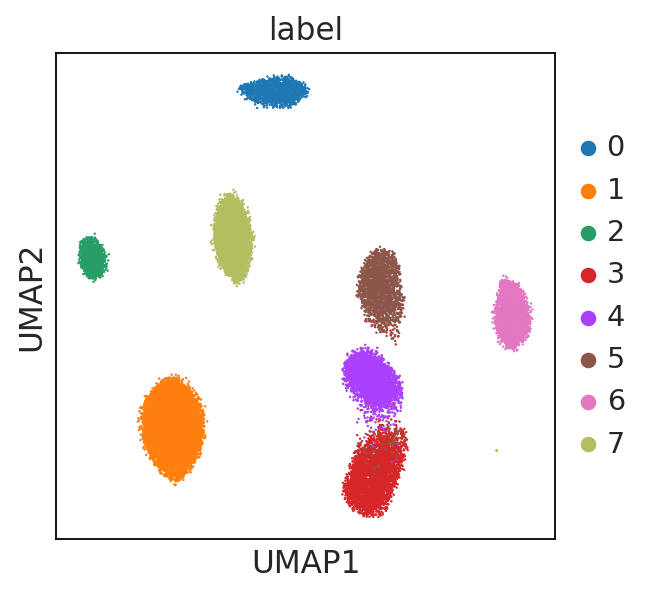

In [66]:
# sc.tl.pca(adata,n_comps=50)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
sc.pl.umap(adata, color='label',palette=adata.uns['cutpred_colors'])

In [42]:
sc.tl.pca(adata_npp,n_comps=50)
sc.pp.neighbors(adata_npp)
sc.tl.umap(adata_npp)


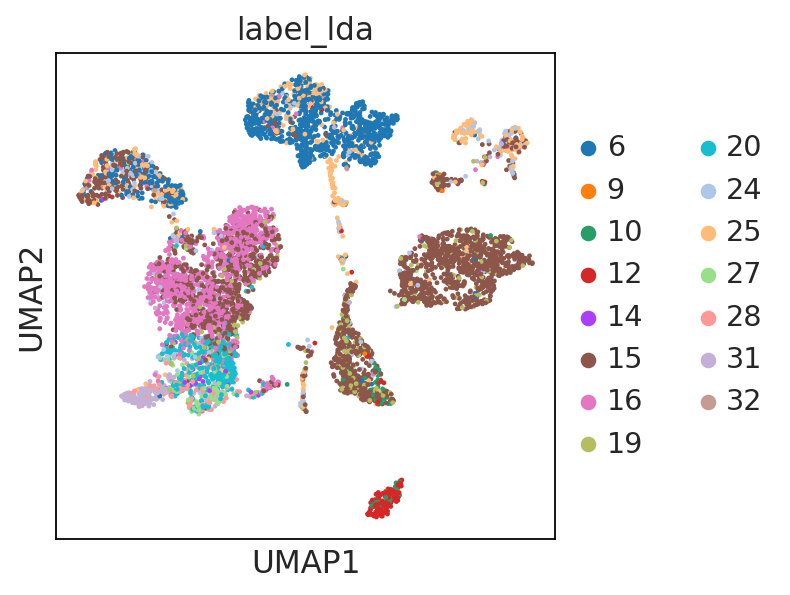

In [70]:
adata_npp.obs['label_lda'] = pred_new.astype(str)
sc.pl.umap(adata_npp,color='label_lda')

In [117]:
[node.ind for node in traversal.nodelist]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [57]:

genes = list(set(list(dedict[1])+list(dedict[2])))
# adata_sub = adata_npp[adata_npp.obs['label'].isin(['Memory B','Naive B']),genes].copy()
adata_sub = adata[traversal.nodelist[0].indices,genes].copy()
# adata_sub = adata[adata.obs['label'].isin(['Memory B','Naive B']),genes].copy()
y = np.dot(adata_sub.X,coefdict[0].T) 

In [55]:
adata_sub.obs['label_plt'] = adata_sub.obs['label'].cat.rename_categories(new_categories={'Naive B':0,'Memory B':1})#{'CD14 Mono':0,'Platelet':1,'Plasmablast':2,'cDC2':3})'CD4 TEM' :1,'CD8 Naive':2,'CD8 TCM' :3,'CD4 Naive':4})
# adata_sub.obs['label_plt'] = adata_sub.obs['pred_rna'].cat.rename_categories(new_categories={'13_leaf':0, '14_leaf':1})#,'17_leaf':2,'18_leaf':3})
# adata_sub.obs['label_plt'] = adata_sub.obs['label_lda'].astype(int)

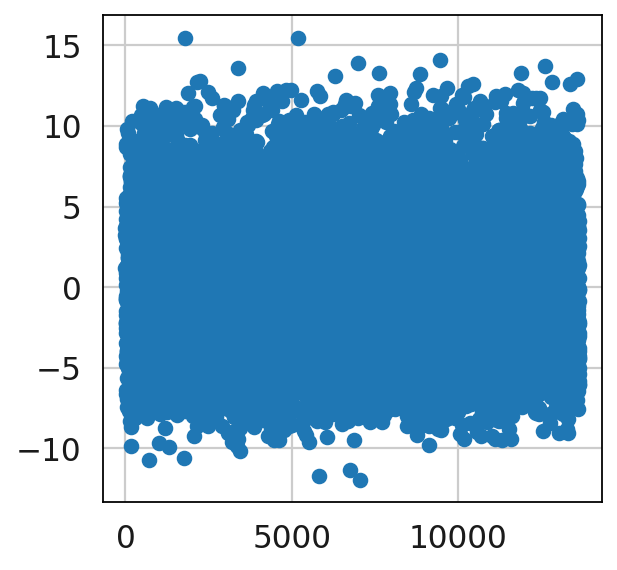

In [58]:
import matplotlib.pyplot as plt

plt.scatter(range(len(y)),y[:,0])

In [71]:
adata_npp.obs['label_lda_'] = adata_npp.obs['label_lda'].cat.rename_categories(
                                {'16':'CD4 Memory','15': "CD4 Naive",'6':'CD14 Mono','25':'cDC2','31':'NK','10':'Memory B','12':'Naive B','32':'CD16 Mono','19':'CD8 Naive','20':'CD8 memory','28':'CD8 Effector_1','14':'CD8 Effector_2'})
adata_npp.obs['label_lda_'].cat.remove_categories(['9','24','27'],inplace=True)

/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [54]:
adata_npp.obs['label_lda_'] = adata_npp.obs['label_lda_'].cat.reorder_categories(new_categories=['CD4 TEM', 'CD4 Naive', 'CD8 Naive', 'CD8 TCM', 'CD8 TEM' ])

/tmp/ipykernel_3251821/2238412075.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  label_latent = pd.Series(index=adata_new.obs_names)


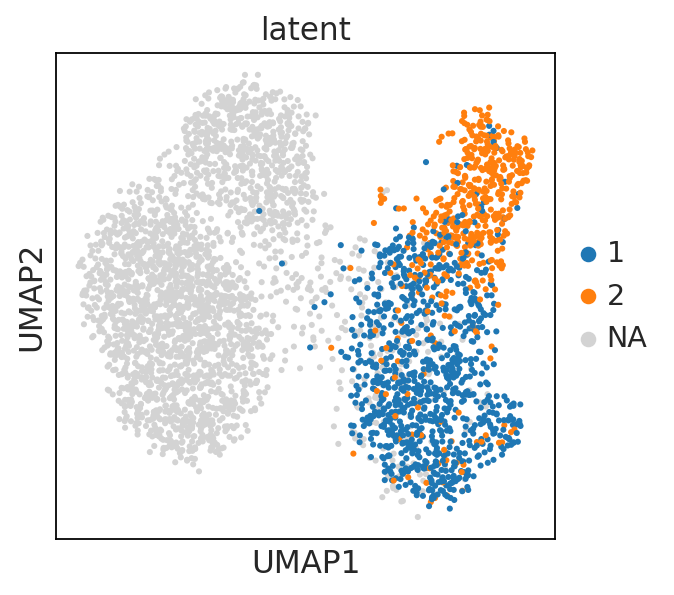

In [86]:
label_latent = pd.Series(index=adata_new.obs_names)
label_latent.loc[newdict[5]] = '1'
label_latent.loc[newdict[6]] = '2'

adata_npp.obs['latent'] = label_latent
sc.pl.umap(adata_npp,color='latent')

In [20]:
adata_npp.uns_keys

<bound method AnnData.uns_keys of AnnData object with n_obs × n_vars = 6196 × 33538
    obs: 'label_l1', 'label_l2', 'donor', 'time', 'label_l3', 'lane', 'n_genes', 'label_lda', 'label_lda_'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'label_lda_colors', 'label_l2_colors', 'label_lda__colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'>

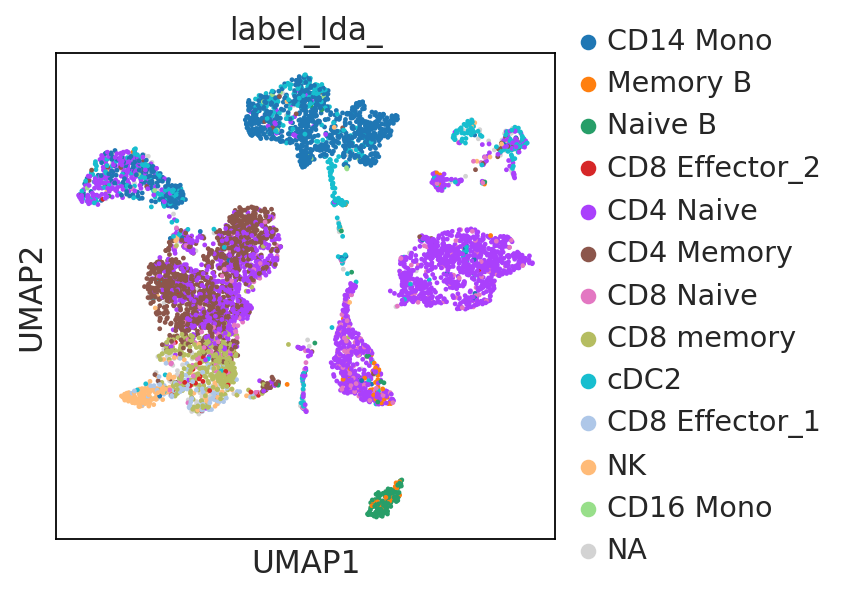

In [72]:
# idnew = '2_2'
# label = pd.read_csv('../simulator_out/droplets_composition_'+idnew+'.csv')
# label.index = label.index.astype(str)
# label['cell_type'] = label.loc[:,'0'].astype(str)
# adata_npp.obs['label'] = label['cell_type']

# label = pd.read_csv('../data/bmmc/BMMC_2_label.csv',index_col=0)
# adata_npp.obs['label'] = label['gating'].astype(str)

sc.pl.umap(adata_npp,color='label_lda_')

In [24]:
label = pd.read_csv('../data/bmmc/bmmc2_new gating_cluster.csv',index_col=0)


In [25]:
label.index = [x.split(':')[0]+'.'+x.split(':')[1] for x in label.index]
label.index = [x.split('-')[0]+'.'+x.split('-')[1] for x in label.index]

In [74]:
label.loc[:,'gating'] = label.iloc[:,1]

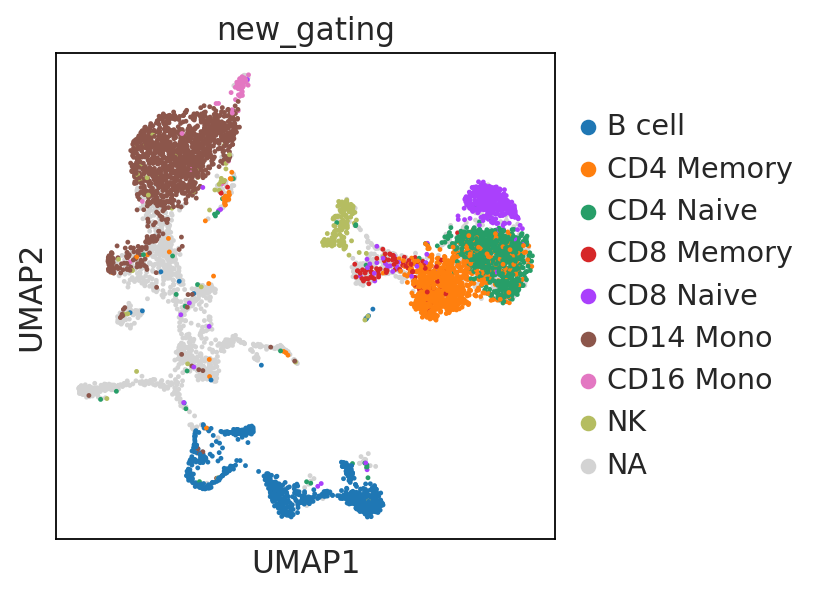

In [39]:
adata_npp.obs['new_gating'] = label['New gating']
sc.pl.umap(adata_npp,color='new_gating')

In [32]:
adata_npp.obs['new_gating']

2        NaN
6        NaN
7        NaN
11       NaN
12       NaN
        ... 
20281    NaN
20283    NaN
20284    NaN
20285    NaN
20286    NaN
Name: new_gating, Length: 9578, dtype: object

In [81]:
label['citesort2'] = adata_npp.obs['label_lda_']

In [82]:
label.to_csv('../data/bmmc/BMMC_2_label.csv')